## Transformer Time-Series Forecast with TCLab

Transformers have revolutionized the field of Natural Language Processing (NLP) and are increasingly being used in time-series forecasting. In this exercise, we develop a model of the dynamic temperature response of the TCLab and compare the Transformer model prediction to measurements. Use the 4 hours of dynamic data from a TCLab (14400 data points = 1 second sample rate for 4 hours) for training and generate new data (840 data points = 1 second sample rate for 14 min) for validation. See [course website](https://apmonitor.com/do/index.php/Main/TransformerForecast) for additional information.

<img width=550px src='https://apmonitor.com/do/uploads/Main/transformers_overview.png'>

### Data Preparation

Load the TCLab training data, scale the inputs (temperature and heater values) and output (temperature), and then format the data into windows.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load training data
file = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data3.txt'
train = pd.read_csv(file)

# Scale features: here we use T1 (temperature) and Q1 (heater) as inputs.
scaler_X = MinMaxScaler(feature_range=(-1,1))
Xs = scaler_X.fit_transform(train[['T1','Q1']])

# Scale predicted value: T1 (temperature)
scaler_Y = MinMaxScaler(feature_range=(-1,1))
Ys = scaler_Y.fit_transform(train[['T1']])

# Create sequences: using a window of past time steps (e.g. 70 steps)
window = 70
X_data = []
Y_data = []
for i in range(window, len(Xs)):
    X_data.append(Xs[i-window:i, :])
    Y_data.append(Ys[i])
X_data, Y_data = np.array(X_data), np.array(Y_data)

### Implement a Simple Transformer Block

Use Keras built-in MultiHeadAttention layer. Include a simple positional encoding layer to add information about the order of the sequence.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)
    
    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        # apply sin to even indices and cos to odd indices
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer Block Layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Build the Transformer Model

The model projects the input sequence to an embedding space, adds positional encoding, passes the data through one or more Transformer blocks, and then uses global pooling plus a Dense output layer to predict the next temperature value.

In [9]:
def create_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    # Project inputs to embedding space
    x = layers.Dense(embed_dim)(inputs)
    # Add positional encoding
    x = PositionalEncoding(input_shape[0], embed_dim)(x)
    # Stack Transformer blocks
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    # Pool and output
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define model parameters
input_shape = (window, X_data.shape[2])  # (window, 2 features: T1 and Q1)
embed_dim = 64      # Embedding dimension for the projection
num_heads = 4       # Number of attention heads
ff_dim = 128        # Hidden layer size in feed-forward network
num_blocks = 2      # Number of Transformer blocks

# Create and compile the Transformer model
model = create_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_blocks, dropout_rate=0.2)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 70, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 70, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_2                │ (None, 70, 64)              │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 70, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 70, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,657 (651.00 KB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Transformer Model

Train the model on the prepared training data.

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - loss: 0.4998
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - loss: 0.0210
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - loss: 0.0078
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - loss: 0.0051
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - loss: 0.0040
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - loss: 0.0035
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 0.0031
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 0.0030
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - loss: 0.0026
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 0.0024


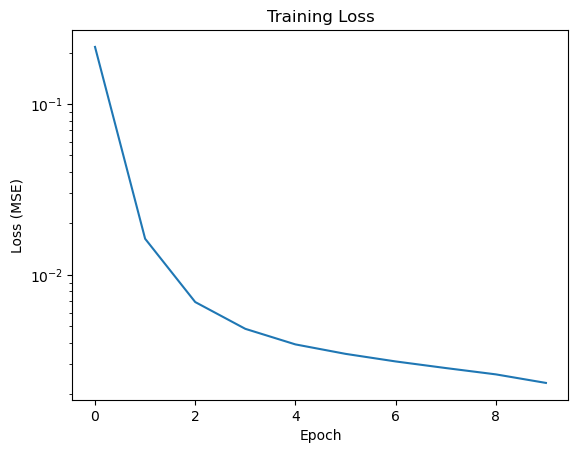

In [10]:
history = model.fit(X_data, Y_data, epochs=10, batch_size=250, verbose=1)

# Plot the training loss history
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()

### Prediction and Validation

Next, use the trained Transformer to predict the temperature and compare its output against the measured values. In this example, predict on the training data; similarly adapt the code for the separate validation dataset.
plt.show()


448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


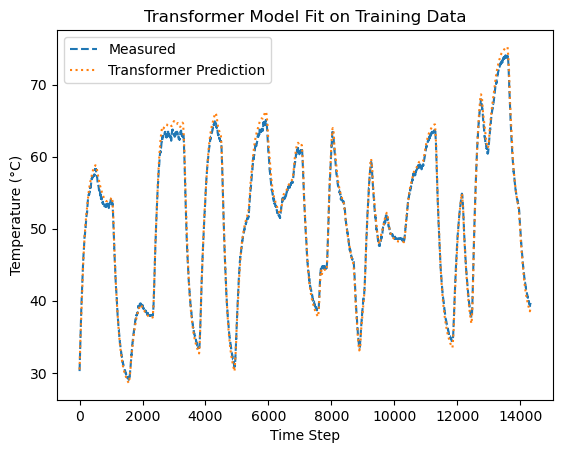

In [11]:
# Predict on the training data
Y_pred = model.predict(X_data)
Y_pred_inv = scaler_Y.inverse_transform(Y_pred)
Y_true_inv = scaler_Y.inverse_transform(Y_data)

plt.figure()
plt.plot(Y_true_inv, '--', label='Measured')
plt.plot(Y_pred_inv, ':', label='Transformer Prediction')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Transformer Model Fit on Training Data')
plt.show()

Validation with a separate data file (14-minute TCLab validation data). Follow a similar pre‐processing routine to create input windows, then generate predictions.

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

C:\Users\johnh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\johnh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


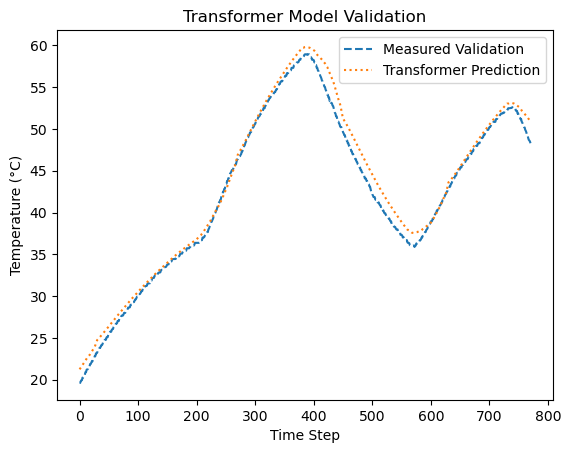

In [13]:
# Load validation data
val_data = pd.read_csv('https://apmonitor.com/pdc/uploads/Main/tclab_data4.txt')
X_val = val_data[['T1','Q1']].values
Y_val = val_data[['T1']].values

# Scale validation data
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)

# Build sequences from validation data
X_val_seq = []
Y_val_seq = []
for i in range(window, len(X_val_scaled)):
    X_val_seq.append(X_val_scaled[i-window:i, :])
    Y_val_seq.append(Y_val_scaled[i])
X_val_seq, Y_val_seq = np.array(X_val_seq), np.array(Y_val_seq)

# Predict on validation set
Y_val_pred = model.predict(X_val_seq)
Y_val_pred_inv = scaler_Y.inverse_transform(Y_val_pred)
Y_val_true_inv = scaler_Y.inverse_transform(Y_val_seq)

plt.figure()
plt.plot(Y_val_true_inv, '--', label='Measured Validation')
plt.plot(Y_val_pred_inv, ':', label='Transformer Prediction')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Transformer Model Validation')
plt.show()

### Forecast Mode

Test the model performance in forecast mode where predictions are fed back into the input sequence instead of using actual temperature measurements. Iteratively update the input data with predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━

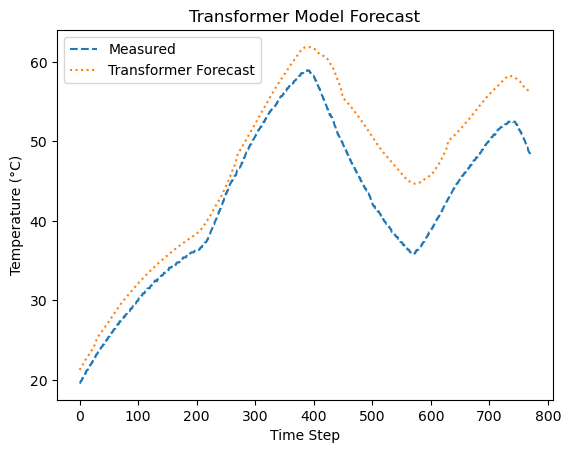

In [14]:
# Create a copy of validation inputs for forecasting
X_val_forecast = X_val_scaled.copy()

# Iteratively update the T1 column (first column) with predictions
for i in range(window, len(X_val_forecast)):
    seq = X_val_forecast[i-window:i, :].reshape(1, window, X_val_scaled.shape[1])
    pred_temp = model.predict(seq)
    # Replace the measured temperature with the predicted value
    X_val_forecast[i, 0] = pred_temp[0, 0]

# Extract forecasted temperature values and inverse-transform
Y_forecast = X_val_forecast[window:, 0]
Y_forecast_inv = scaler_Y.inverse_transform(Y_forecast.reshape(-1, 1))

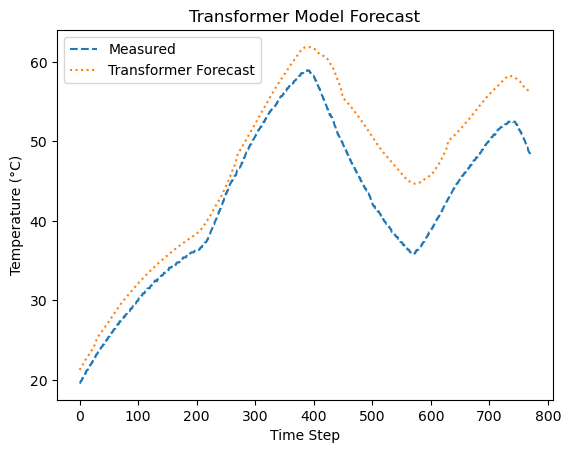

In [15]:
plt.figure()
plt.plot(Y_val_true_inv, '--', label='Measured')
plt.plot(Y_forecast_inv, ':', label='Transformer Forecast')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Transformer Model Forecast')
plt.show()